In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from transformers import AutoTokenizer
from difflib import SequenceMatcher

Dataset Used: UCSC-VLAA/MedReason  
https://huggingface.co/datasets/UCSC-VLAA/MedReason

In [94]:
df = pd.read_json("hf://datasets/UCSC-VLAA/MedReason/ours_quality_33000.jsonl", lines=True)
df.head()

,dataset_name,id_in_dataset,question,answer,reasoning,options
0,medmcqa,7131,Urogenital Diaphragm is made up of the followi...,Colle's fascia. Explanation: Colle's fascia do...,Finding reasoning paths:\n1. Urogenital diaphr...,Answer Choices:\nA. Deep transverse Perineus\n...
1,medmcqa,7133,Child with Type I Diabetes. What is the advise...,After 5 years. Explanation: Screening for diab...,**Finding reasoning paths:**\n\n1. Type 1 Diab...,Answer Choices:\nA. After 5 years\nB. After 2 ...
2,medmcqa,7134,Most sensitive test for H pylori is-,Biopsy urease test. Explanation: <P>Davidson&;...,**Finding reasoning paths:**\n\n1. Consider th...,Answer Choices:\nA. Fecal antigen test\nB. Bio...
3,medmcqa,7137,Ligation of the common hepatic aery will compr...,Right gastric and right gastroepiploic aery. E...,**Finding reasoning paths:**\n\n1. Common hepa...,Answer Choices:\nA. Right and Left gastric aer...
4,medmcqa,7138,Typhoid investigation of choice in 1st week,Blood culture. Explanation: (A) Blood culture ...,Finding reasoning paths:\n\n1. Consider the pa...,Answer Choices:\nA. Blood culture\nB. Widal te...


# General Information

In [95]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32682 entries, 0 to 32681
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dataset_name   32682 non-null  object
 1   id_in_dataset  32682 non-null  int64 
 2   question       32682 non-null  object
 3   answer         32682 non-null  object
 4   reasoning      32682 non-null  object
 5   options        32682 non-null  object
dtypes: int64(1), object(5)
memory usage: 187.0 MB


In [96]:
df.shape

(32682, 6)

In [97]:
df.columns

Index(['dataset_name', 'id_in_dataset', 'question', 'answer', 'reasoning',
       'options'],
      dtype='object')

In [98]:
df.dtypes

,0
dataset_name,object
id_in_dataset,int64
question,object
answer,object
reasoning,object
options,object


Null check

In [ ]:
print(df.isnull().sum())

dataset_name     0
id_in_dataset    0
question         0
answer           0
reasoning        0
options          0
dtype: int64


In [ ]:
print((df == '').sum())

dataset_name        0
id_in_dataset       0
question            0
answer              0
reasoning           0
options          7198
dtype: int64


# Exploratory Data Analysis

In [99]:
# Finding number of unique dataset sources from dataset_name
df['dataset_name'].nunique()

9

In [100]:
data_sources = df['dataset_name'].unique()
data_sources

array(['medmcqa', 'huatuo', 'medqa', 'pubmedqa_unlabeled', 'MMLU',
       'pubmedqa', 'LastHumanity', 'pubmedqa_artificial', 'MedXpertQA'],
      dtype=object)

In [101]:
# Num questions from each source
df['dataset_name'].value_counts()

,count
dataset_name,
pubmedqa_artificial,8094
medqa,8016
huatuo,6475
medmcqa,6197
pubmedqa_unlabeled,1747
MMLU,827
MedXpertQA,666
pubmedqa,603
LastHumanity,57


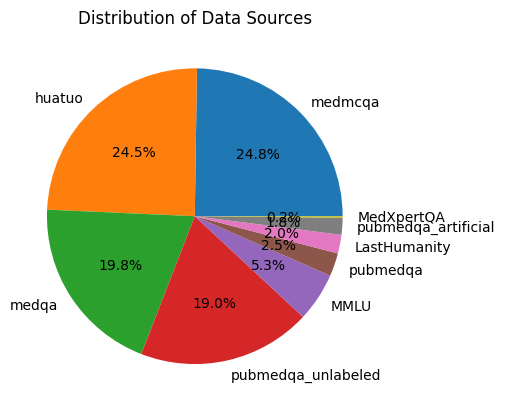

In [102]:
# Pie chart of counts from each source
plt.pie(df['dataset_name'].value_counts(), labels=data_sources, autopct='%1.1f%%')
plt.title('Distribution of Data Sources')
plt.show()


In [104]:
df['question_char_len'] = df['question'].apply(len)
df['answer_char_len'] = df['answer'].apply(len)

print(df[['question_char_len', 'answer_char_len']].describe())



       question_char_len  answer_char_len
count       32682.000000     32682.000000
mean          322.388777       319.890001
std           348.816164       387.175156
min             6.000000         1.000000
25%            92.000000        38.000000
50%           145.000000       232.000000
75%           489.000000       444.000000
max         13498.000000     12866.000000


In [105]:
df['question_word_count'] = df['question'].apply(lambda x: len(x.split()))
df['answer_word_count'] = df['answer'].apply(lambda x: len(x.split()))

print(df[['question_word_count', 'answer_word_count']].describe())

       question_word_count  answer_word_count
count         32682.000000       32682.000000
mean             50.256839          46.674041
std              55.746483          55.520484
min               1.000000           1.000000
25%              13.000000           5.000000
50%              21.000000          34.000000
75%              77.000000          65.000000
max            1987.000000        1263.000000


In [107]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

df['question_token_count'] = df['question'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False, truncation=False)))
df['answer_token_count'] = df['answer'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False, truncation=False)))

print(df[['question_token_count', 'answer_token_count']].describe())


Token indices sequence length is longer than the specified maximum sequence length for this model (645 > 512). Running this sequence through the model will result in indexing errors


       question_token_count  answer_token_count
count          32682.000000        32682.000000
mean              74.599841           72.219785
std               84.108506           92.893458
min                2.000000            1.000000
25%               20.000000           10.000000
50%               33.000000           51.000000
75%              110.000000           98.000000
max             3164.000000         4223.000000


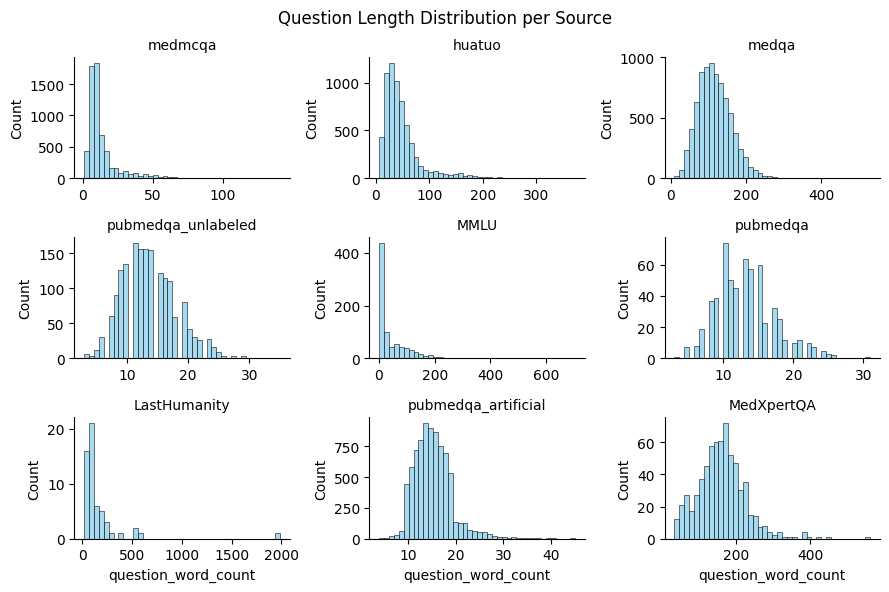

In [108]:
g = sns.FacetGrid(df, col="dataset_name", col_wrap=3, height=3, sharex=False, sharey=False)
g.map(sns.histplot, "question_word_count", bins=40, color="skyblue")
g.set_titles(col_template="{col_name}")
g.fig.suptitle("Question Length Distribution per Source", fontsize=12)
g.fig.set_size_inches(9, 6)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

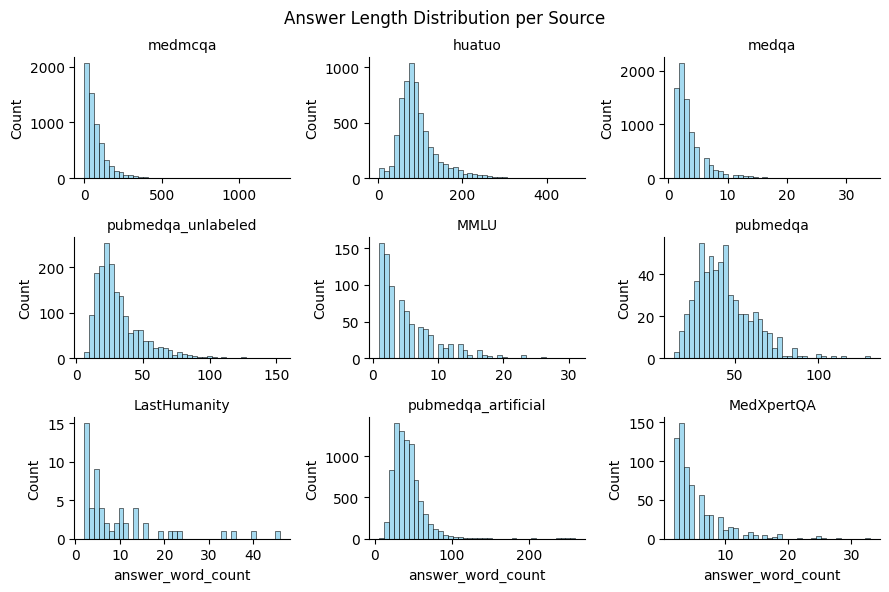

In [109]:
g = sns.FacetGrid(df, col="dataset_name", col_wrap=3, height=3, sharex=False, sharey=False)
g.map(sns.histplot, "answer_word_count", bins=40, color="skyblue")
g.set_titles(col_template="{col_name}")
g.fig.suptitle("Answer Length Distribution per Source", fontsize=12)
g.fig.set_size_inches(9, 6)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [110]:
# Answer length statistics per data source
df.groupby('dataset_name')['answer_word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
dataset_name,,,,,,,,
LastHumanity,57.0,9.666667,9.695974,2.0,3.0,6.0,11.0,46.0
MMLU,827.0,5.214027,4.645693,1.0,2.0,4.0,7.0,31.0
MedXpertQA,666.0,5.433934,4.152650,2.0,3.0,4.0,7.0,33.0
huatuo,6475.0,92.722162,46.749890,2.0,63.0,83.0,109.0,468.0
medmcqa,6197.0,75.380829,86.333744,1.0,23.0,54.0,98.0,1263.0
medqa,8016.0,3.522829,3.044028,1.0,2.0,3.0,4.0,34.0
pubmedqa,603.0,43.611940,16.527396,14.0,31.0,41.0,53.0,131.0
pubmedqa_artificial,8094.0,41.926242,17.886496,6.0,30.0,39.0,50.0,259.0
pubmedqa_unlabeled,1747.0,31.780195,18.158737,6.0,19.0,26.0,38.0,153.0


## Dataset Sources


### medmcqa

In [111]:
# View sample from medmcqa
medmcqa_qs = df[df['dataset_name'] == 'medmcqa'].copy()
medmcqa_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options,question_char_len,answer_char_len,question_word_count,answer_word_count,question_token_count,answer_token_count
0,medmcqa,7131,Urogenital Diaphragm is made up of the followi...,Colle's fascia. Explanation: Colle's fascia do...,Finding reasoning paths:\n1. Urogenital diaphr...,Answer Choices:\nA. Deep transverse Perineus\n...,57,343,9,54,16,94
1,medmcqa,7133,Child with Type I Diabetes. What is the advise...,After 5 years. Explanation: Screening for diab...,**Finding reasoning paths:**\n\n1. Type 1 Diab...,Answer Choices:\nA. After 5 years\nB. After 2 ...,104,592,18,96,21,144
2,medmcqa,7134,Most sensitive test for H pylori is-,Biopsy urease test. Explanation: <P>Davidson&;...,**Finding reasoning paths:**\n\n1. Consider th...,Answer Choices:\nA. Fecal antigen test\nB. Bio...,36,178,7,21,10,50
3,medmcqa,7137,Ligation of the common hepatic aery will compr...,Right gastric and right gastroepiploic aery. E...,**Finding reasoning paths:**\n\n1. Common hepa...,Answer Choices:\nA. Right and Left gastric aer...,65,403,11,54,15,125
4,medmcqa,7138,Typhoid investigation of choice in 1st week,Blood culture. Explanation: (A) Blood culture ...,Finding reasoning paths:\n\n1. Consider the pa...,Answer Choices:\nA. Blood culture\nB. Widal te...,43,1360,7,239,9,339
...,...,...,...,...,...,...,...,...,...,...,...,...
29157,medmcqa,7125,A 60-year-old nursing home resident presents w...,Contact precautions. Explanation: There are fo...,### Finding Reasoning Paths:\n1. **Clinical Pr...,Answer Choices:\nA. Standard precautions\nB. C...,340,1610,45,238,77,310
29158,medmcqa,7126,Transcripton is inhibited by:,Actinomycin D. Explanation: A i.e. Actinomycin,### Finding Reasoning Paths:\n1. mRNA transcri...,Answer Choices:\nA. Actinomycin D\nB. Amanitin...,29,46,4,6,7,17
29159,medmcqa,7128,Triage is –,Categorisation of the patients and treating th...,### Finding Reasoning Paths:\n1. **Severity of...,Answer Choices:\nA. Treating the most serious ...,11,715,3,103,4,128
29160,medmcqa,7129,All of the following are true in respect of he...,Autosomal recessive disorder. Explanation: Her...,### Finding Reasoning Paths:\n1. **Complement ...,Answer Choices:\nA. Deficiency of C1 inhibitor...,89,531,14,73,23,123


In [ ]:
for i in range(5):
    print(medmcqa_qs.iloc[i]['answer'])
    print()

Colle's fascia. Explanation: Colle's fascia does not contribute to the Urogenital Diaphragm. It is attached posteriorly to the posterior border of the urogenital diaphragm but does not form pa of this diaphragm. Ref: BDC, Volume 2, 4th Edition, Page 332; Grants Method of Anatomy, 11th Edition, Page 244; Gray's Anatomy, 36th Edition, Page 563

After 5 years. Explanation: Screening for diabetic retinopathy To prevent visual loss occurring from diabetic retinopathy a periodic follow-up is very impoant for a timely intervention. The recommendations for periodic fundus examination are as follows : First examination, 5 years after diagnosis of type 1 DM and at the time of diagnosis in type 2 DM. Every year, till there is no diabetic retinopathy or there is mild NPDR. Every 6 months, in moderate NPDR. Every 3 months, in severe NPDR Every 2 months, in PDR with no high-risk characteristics. Ref;A.K.Khurana; 6th edition; Page no: 280

Biopsy urease test. Explanation: <P>Davidson&;s principles an

In [ ]:
for i in range(5):
    print(medmcqa_qs.iloc[i]['options'])
    print()

Answer Choices:
A. Deep transverse Perineus
B. Perinial membrane
C. Colle's fascia
D. Sphincter Urethrae

Answer Choices:
A. After 5 years
B. After 2 years
C. After 10 years
D. At the time of diagnosis

Answer Choices:
A. Fecal antigen test
B. Biopsy urease test
C. Serological test
D. Urea breath test

Answer Choices:
A. Right and Left gastric aery
B. Right gastric and sho gastric aeries
C. Right gastroepiploic and sho gastric aeries
D. Right gastric and right gastroepiploic aery

Answer Choices:
A. Blood culture
B. Widal test
C. Stool culture
D. Urine culture



In [ ]:
def count_answer_choices(text):
    if pd.isnull(text):
        return 0
    lines = text.strip().split('\n')
    choice_lines = lines[1:]
    count = sum(bool(re.match(r'^[A-Z]\.', line.strip())) for line in choice_lines)
    return count

medmcqa_qs['num_choices'] = medmcqa_qs['options'].apply(count_answer_choices)

print(medmcqa_qs['num_choices'].value_counts())


num_choices
4    6197
Name: count, dtype: int64


In [145]:
def extract_mcq_label(answer_text, options_text):
    """
    answer_text: the answer string containing the actual answer, e.g., 'Colle's fascia. Explanation: ...'
    options_text: the options string, e.g.,
        'Answer Choices:\nA. Deep transverse Perineus\nB. Perinial membrane\nC. Colle's fascia\nD. Sphincter Urethrae'
    Returns: the letter corresponding to the correct option, e.g., 'C'
    """
    # Extract just the answer before "Explanation:" (first sentence)
    answer_main = answer_text.split("Explanation:")[0].strip().rstrip('.')

    # Split options into letter + text
    matches = re.findall(r'([A-D])\.\s*(.*)', options_text)

    # Check which option text matches the answer (case-insensitive)
    for letter, text in matches:
        if text.strip().lower() == answer_main.lower():
            return letter
    return None  # if no match found


In [168]:
def clean_text(text):
    """Lowercase, remove newlines/tabs/extra spaces, strip, remove trailing period."""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # replace all whitespace (including \n, \t) with single space
    text = text.strip()
    text = text.rstrip('.')
    return text

def extract_mcq_label_fuzzy(answer_text, options_text, threshold=0.9):
    """
    Extracts MCQ letter (A-D) corresponding to the correct answer using fuzzy matching.
    Only uses cleaned text for matching; original text remains unchanged.
    """
    # Clean main answer (before Explanation:)
    answer_main = clean_text(answer_text.split("Explanation:")[0])

    # Extract options
    matches = re.findall(r'([A-D])\.\s*(.*)', options_text)

    best_letter = None
    best_ratio = 0

    for letter, text in matches:
        option_text = clean_text(text)
        ratio = SequenceMatcher(None, answer_main, option_text).ratio()
        if ratio > best_ratio and ratio >= threshold:
            best_ratio = ratio
            best_letter = letter

    return best_letter

In [169]:
medmcqa_qs['answer_label'] = medmcqa_qs.apply(lambda row: extract_mcq_label(row['answer'], row['options']), axis=1)
medmcqa_qs['answer_label_fuzzy'] = medmcqa_qs.apply(lambda row: extract_mcq_label_fuzzy(row['answer'], row['options']), axis=1)


In [132]:
medmcqa_qs[['answer', 'options', 'answer_label']]

,answer,options,answer_label
0,Colle's fascia. Explanation: Colle's fascia do...,Answer Choices:\nA. Deep transverse Perineus\n...,C
1,After 5 years. Explanation: Screening for diab...,Answer Choices:\nA. After 5 years\nB. After 2 ...,A
2,Biopsy urease test. Explanation: <P>Davidson&;...,Answer Choices:\nA. Fecal antigen test\nB. Bio...,B
3,Right gastric and right gastroepiploic aery. E...,Answer Choices:\nA. Right and Left gastric aer...,D
4,Blood culture. Explanation: (A) Blood culture ...,Answer Choices:\nA. Blood culture\nB. Widal te...,A
...,...,...,...
29157,Contact precautions. Explanation: There are fo...,Answer Choices:\nA. Standard precautions\nB. C...,B
29158,Actinomycin D. Explanation: A i.e. Actinomycin,Answer Choices:\nA. Actinomycin D\nB. Amanitin...,A
29159,Categorisation of the patients and treating th...,Answer Choices:\nA. Treating the most serious ...,B
29160,Autosomal recessive disorder. Explanation: Her...,Answer Choices:\nA. Deficiency of C1 inhibitor...,D


In [150]:
medmcqa_qs['answer_label'].value_counts(dropna=False)

,count
answer_label,
A,1894
B,1541
C,1502
D,1172
None,88


In [170]:
medmcqa_qs['answer_label_fuzzy'].value_counts(dropna=False)

,count
answer_label_fuzzy,
A,1921
B,1554
C,1528
D,1194


In [158]:
# Print answers, options and answer_label_fuzzy for 10 rows to check
i = 0
for index, row in medmcqa_qs.iterrows():
    if i == 10:
        break
    print(f"{row['options']}")
    print(f"Answer: {row['answer']}")
    print(f"Answer Label Fuzzy: {row['answer_label_fuzzy']}")
    print()

    i +=1


Answer Choices:
A. Deep transverse Perineus
B. Perinial membrane
C. Colle's fascia
D. Sphincter Urethrae
Answer: Colle's fascia. Explanation: Colle's fascia does not contribute to the Urogenital Diaphragm. It is attached posteriorly to the posterior border of the urogenital diaphragm but does not form pa of this diaphragm. Ref: BDC, Volume 2, 4th Edition, Page 332; Grants Method of Anatomy, 11th Edition, Page 244; Gray's Anatomy, 36th Edition, Page 563
Answer Label Fuzzy: C

Answer Choices:
A. After 5 years
B. After 2 years
C. After 10 years
D. At the time of diagnosis
Answer: After 5 years. Explanation: Screening for diabetic retinopathy To prevent visual loss occurring from diabetic retinopathy a periodic follow-up is very impoant for a timely intervention. The recommendations for periodic fundus examination are as follows : First examination, 5 years after diagnosis of type 1 DM and at the time of diagnosis in type 2 DM. Every year, till there is no diabetic retinopathy or there is 

In [151]:
medmcqa_qs[['question', 'answer', 'answer_label_fuzzy']]

,question,answer,answer_label_fuzzy
0,Urogenital Diaphragm is made up of the followi...,Colle's fascia. Explanation: Colle's fascia do...,C
1,Child with Type I Diabetes. What is the advise...,After 5 years. Explanation: Screening for diab...,A
2,Most sensitive test for H pylori is-,Biopsy urease test. Explanation: <P>Davidson&;...,B
3,Ligation of the common hepatic aery will compr...,Right gastric and right gastroepiploic aery. E...,D
4,Typhoid investigation of choice in 1st week,Blood culture. Explanation: (A) Blood culture ...,A
...,...,...,...
29157,A 60-year-old nursing home resident presents w...,Contact precautions. Explanation: There are fo...,B
29158,Transcripton is inhibited by:,Actinomycin D. Explanation: A i.e. Actinomycin,A
29159,Triage is –,Categorisation of the patients and treating th...,B
29160,All of the following are true in respect of he...,Autosomal recessive disorder. Explanation: Her...,D


In [159]:
# Set answer_label to use fuzzy
medmcqa_qs['answer_label'] = medmcqa_qs['answer_label_fuzzy']

MedMCQA: MCQ with 4 options -> Keep in final dataset

### huatuo

In [ ]:
# View sample from huatuo
huatuo_qs = df[df['dataset_name'] == "huatuo"].copy()
huatuo_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options
1306,huatuo,0,A 61-year-old woman with a long history of inv...,Cystometry in this case of stress urinary inco...,### Finding Reasoning Paths:\n1. Female stress...,
1307,huatuo,1,A 45-year-old man with a history of alcohol us...,Considering the clinical presentation of sudde...,### Finding Reasoning Paths:\n1. Chronic liver...,
1308,huatuo,2,A 45-year-old man presents with symptoms inclu...,Based on the clinical findings presented—wide-...,### Finding Reasoning Paths:\n1. Broad-based g...,
1309,huatuo,3,A patient with psoriasis was treated with syst...,The development of generalized pustules in a p...,### Finding Reasoning Paths:\n1. Psoriasis -> ...,
1310,huatuo,4,What is the most likely diagnosis for a 2-year...,Based on the described symptoms and the unusua...,### Finding Reasoning Paths:\n1. **Overweight ...,
...,...,...,...,...,...,...
23593,huatuo,6504,A large city has motor vehicles that produced ...,The total number of moles of carbon monoxide (...,### Finding Reasoning Paths:\n1. **Path 1**: U...,
23594,huatuo,6505,How should a 35-week pregnant female presentin...,A 35-week pregnant female presenting with seve...,### Finding Reasoning Paths:\n1. **Preeclampsi...,
23595,huatuo,6506,To which organelle are proteins directed when ...,Proteins synthesized by ribosomes attached to ...,### Finding Reasoning Paths:\n1. Ribosome → Ro...,
23596,huatuo,6508,A man with an upper abdominal injury shows sym...,Based on the symptoms described—right upper qu...,### Finding Reasoning Paths:\n1. **Right upper...,


In [ ]:
for i in range(5):
    print(huatuo_qs.iloc[i]['answer'])
    print()

Cystometry in this case of stress urinary incontinence would most likely reveal a normal post-void residual volume, as stress incontinence typically does not involve issues with bladder emptying. Additionally, since stress urinary incontinence is primarily related to physical exertion and not an overactive bladder, you would not expect to see any involuntary detrusor contractions during the test.

Considering the clinical presentation of sudden onset dysarthria, shuffling gait, and intention tremors in a 45-year-old man with a history of alcohol use who has been abstinent for the past 10 years, the most likely diagnosis is acquired hepatocerebral degeneration.

This condition is associated with chronic liver disease, which can often be a consequence of long-term alcohol use. Despite the patient's abstinence from alcohol for a decade, previous alcohol use may have led to underlying liver dysfunction. This dysfunction, even if subclinical, can cause encephalopathy due to the accumulation

In [ ]:
huatuo_qs['options'].value_counts()

,count
options,
,6475


huatuo: Open ended answers -> Filter out for now

### pubmedqa

In [112]:
pubmedqa_qs = df[df['dataset_name'] == "pubmedqa"].copy()
pubmedqa_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options,question_char_len,answer_char_len,question_word_count,answer_word_count,question_token_count,answer_token_count
13055,pubmedqa,0,Do mitochondria play a role in remodelling lac...,The final decision is: yes. Results depicted m...,### Finding Reasoning Paths:\n1. Mitochondria ...,Answer Choices:\nA. Yes\nB. No,90,645,14,102,21,135
13056,pubmedqa,1,Landolt C and snellen e acuity: differences in...,The final decision is: no. Using the charts de...,### Finding Reasoning Paths:\n1. Strabismus ->...,Answer Choices:\nA. Yes\nB. No,68,258,10,43,22,63
13057,pubmedqa,4,Can tailored interventions increase mammograph...,The final decision is: yes. The effects of the...,### Finding Reasoning Paths:\n1. **Effectivene...,Answer Choices:\nA. Yes\nB. No,68,816,9,110,13,146
13058,pubmedqa,9,A short stay or 23-hour ward in a general and ...,The final decision is: yes. This data demonstr...,### Finding Reasoning Paths:\n1. **Bed Efficie...,Answer Choices:\nA. Yes\nB. No,95,333,16,55,22,62
13059,pubmedqa,11,Therapeutic anticoagulation in the trauma pati...,The final decision is: no. Trauma patients hav...,### Finding Reasoning Paths:\n1. **Response to...,Answer Choices:\nA. Yes\nB. No,62,333,9,46,14,62
...,...,...,...,...,...,...,...,...,...,...,...,...
13653,pubmedqa,993,Are many colorectal cancers due to missed aden...,The final decision is: no. In normal daily pra...,### Finding Reasoning Paths:\n1. Colorectal ca...,Answer Choices:\nA. Yes\nB. No,51,179,8,28,13,38
13654,pubmedqa,994,Does desflurane alter left ventricular functio...,The final decision is: no. This study demonstr...,### Finding Reasoning Paths:\n1. Desflurane's ...,Answer Choices:\nA. Yes\nB. No,112,238,15,33,23,47
13655,pubmedqa,995,Does gestational age misclassification explain...,The final decision is: no. Gestational age mis...,### Finding Reasoning Paths:\n1. Investigate w...,Answer Choices:\nA. Yes\nB. No,115,255,14,34,24,50
13656,pubmedqa,997,Is peak concentration needed in therapeutic dr...,The final decision is: no. These results sugge...,### Finding Reasoning Paths:\n1. Vancomycin ->...,Answer Choices:\nA. Yes\nB. No,74,195,10,31,14,45


In [113]:
for i in range(5):
    print(pubmedqa_qs.iloc[i]['answer'])
    print()

The final decision is: yes. Results depicted mitochondrial dynamics in vivo as PCD progresses within the lace plant, and highlight the correlation of this organelle with other organelles during developmental PCD. To the best of our knowledge, this is the first report of mitochondria and chloroplasts moving on transvacuolar strands to form a ring structure surrounding the nucleus during developmental PCD. Also, for the first time, we have shown the feasibility for the use of CsA in a whole plant system. Overall, our findings implicate the mitochondria as playing a critical and early role in developmentally regulated PCD in the lace plant.

The final decision is: no. Using the charts described, there was only a slight overestimation of visual acuity by the Snellen E compared to the Landolt C, even in strabismus amblyopia. Small differences in the lower visual acuity range have to be considered.

The final decision is: yes. The effects of the intervention were most pronounced after the fi

In [114]:
for i in range(5):
    print(pubmedqa_qs.iloc[i]['options'])
    print()

Answer Choices:
A. Yes
B. No

Answer Choices:
A. Yes
B. No

Answer Choices:
A. Yes
B. No

Answer Choices:
A. Yes
B. No

Answer Choices:
A. Yes
B. No



In [122]:
def extract_decision(text):
    # Regex to find "yes" or "no" after "The final decision is:"
    match = re.search(r"The final decision is:\s*(yes|no|maybe)", text, flags=re.IGNORECASE)
    if match:
        return match.group(1).lower()   # return 'yes' or 'no'
    return None

# Apply to your dataframe
pubmedqa_qs['answer_label'] = pubmedqa_qs['answer'].apply(extract_decision)

# Count distribution
print(pubmedqa_qs['answer_label'].value_counts())

answer_label
yes      421
no       181
maybe      1
Name: count, dtype: int64


In [125]:
# Remove row with answer_label 'maybe'
pubmedqa_qs = pubmedqa_qs[pubmedqa_qs['answer_label'] != 'maybe']
pubmedqa_qs[['question', 'answer', 'answer_label']]

,question,answer,answer_label
13055,Do mitochondria play a role in remodelling lac...,The final decision is: yes. Results depicted m...,yes
13056,Landolt C and snellen e acuity: differences in...,The final decision is: no. Using the charts de...,no
13057,Can tailored interventions increase mammograph...,The final decision is: yes. The effects of the...,yes
13058,A short stay or 23-hour ward in a general and ...,The final decision is: yes. This data demonstr...,yes
13059,Therapeutic anticoagulation in the trauma pati...,The final decision is: no. Trauma patients hav...,no
...,...,...,...
13653,Are many colorectal cancers due to missed aden...,The final decision is: no. In normal daily pra...,no
13654,Does desflurane alter left ventricular functio...,The final decision is: no. This study demonstr...,no
13655,Does gestational age misclassification explain...,The final decision is: no. Gestational age mis...,no
13656,Is peak concentration needed in therapeutic dr...,The final decision is: no. These results sugge...,no


PubMedQA Labeled: Yes/No Questions -> Keep in final dataset

### pubmedqa_unlabeled

In [ ]:
pubmedqa_unlabeled_qs = df[df['dataset_name'] == "pubmedqa_unlabeled"].copy()
pubmedqa_unlabeled_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options,question_length,answer_length
12537,pubmedqa_unlabeled,11515,Can finasteride reverse the progress of benign...,The efficacy of therapy with finasteride 5 mg ...,**Finding reasoning paths:**\n\n1. Benign pros...,Answer Choices:\nA. Yes\nB. No,69,388
12538,pubmedqa_unlabeled,11522,Severe hyponatremia associated with anorexia n...,Hyponatremia sometimes seen in anorexia nervos...,**Finding reasoning paths:**\n\n1. Anorexia ne...,Answer Choices:\nA. Yes\nB. No,107,120
12539,pubmedqa_unlabeled,11529,Can nebulized naloxone be used safely and effe...,Nebulized naloxone is a safe and effective nee...,**Finding reasoning paths:**\n\n1. Acute opioi...,Answer Choices:\nA. Yes\nB. No,114,163
12540,pubmedqa_unlabeled,11543,Can we avoid percutaneous nephrolithotomy in h...,Conservative management of asymptomatic large ...,Finding reasoning paths:\n\n1. Nephrolithiasis...,Answer Choices:\nA. Yes\nB. No,109,151
12541,pubmedqa_unlabeled,11551,Dynamic MDCT of the pancreas: is time-density ...,The morphology of MDCT perfusion time-density ...,**Finding reasoning paths:**\n\n1. **Understan...,Answer Choices:\nA. Yes\nB. No,118,190
...,...,...,...,...,...,...,...,...
30113,pubmedqa_unlabeled,7380,Does stigma keep poor young immigrant and U.S....,Stigma-related concerns are most common among ...,### Finding Reasoning Paths:\n1. **Cultural an...,Answer Choices:\nA. Yes\nB. No,107,188
30114,pubmedqa_unlabeled,7389,Selective mutism and social anxiety disorder: ...,These results support earlier uncontrolled fin...,### Finding Reasoning Paths:\n1. **Familial re...,Answer Choices:\nA. Yes\nB. No,64,120
30115,pubmedqa_unlabeled,7402,Is levofloxacin necessary to prevent postopera...,Levofloxacin is not necessary to prevent posto...,### Finding Reasoning Paths:\n1. **Wound heali...,Answer Choices:\nA. Yes\nB. No,99,122
30116,pubmedqa_unlabeled,7406,Does the energy expenditure status in obstruct...,In apneic men energy expenditure relative to b...,### Finding Reasoning Paths:\n1. Obstructive s...,Answer Choices:\nA. Yes\nB. No,95,160


In [ ]:
for i in range(5):
    print(pubmedqa_unlabeled_qs.iloc[i]['answer'])
    print()

The efficacy of therapy with finasteride 5 mg in improving both symptoms and maximum urinary flow rate and reducing prostate volume has been shown to be maintained during 24 months while patients receiving placebo experienced a return to baseline or deterioration of these parameters during the study. These results demonstrate that finasteride can reverse the natural progression of BPH.

Hyponatremia sometimes seen in anorexia nervosa must lead to the search of inappropriate antidiuretic hormone secretion.

Nebulized naloxone is a safe and effective needleless alternative for prehospital treatment of suspected opioid overdose in patients with spontaneous respirations.

Conservative management of asymptomatic large kidney stones appears to be a safe alternative to PCNL in elderly patients with significant comorbidites.

The morphology of MDCT perfusion time-density curves appears to be useful in characterizing pancreatic lesions, and might help overcome the differences in scan and postpr

PubMedQA Unlabeled: Lack of ground truth values (answers) -> Can be filtered out

### pubmedqa_artificial

In [161]:
pubmedqa_artificial_qs = df[df['dataset_name'] == "pubmedqa_artificial"].copy()
pubmedqa_artificial_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options,question_char_len,answer_char_len,question_word_count,answer_word_count,question_token_count,answer_token_count
13715,pubmedqa_artificial,7391,Do a clinical `` near miss '' highlights risk ...,The final decision is: yes. It is evident that...,### Finding Reasoning Paths:\n1. Breast cancer...,Answer Choices:\nA. Yes\nB. No,131,415,17,66,27,76
13716,pubmedqa_artificial,7392,Is sentinel node biopsy indicated for thin mel...,The final decision is: yes. SLN metastases wer...,### Finding Reasoning Paths:\n1. **Path 1**: E...,Answer Choices:\nA. Yes\nB. No,62,293,10,50,17,82
13717,pubmedqa_artificial,7393,Does serum sclerostin increase in healthy adul...,The final decision is: yes. In healthy men sub...,### Finding Reasoning Paths:\n1. Prolonged bed...,Answer Choices:\nA. Yes\nB. No,68,219,11,36,15,51
13718,pubmedqa_artificial,7394,Does topical application of Sadat-Habdan mesen...,The final decision is: yes. Topical applicatio...,### Finding Reasoning Paths:\n1. **Hyperglycem...,Answer Choices:\nA. Yes\nB. No,128,100,17,15,30,22
13719,pubmedqa_artificial,7396,Do deficits in visuospatial processing contrib...,The final decision is: yes. Deficits in visuos...,### Finding Reasoning Paths:\n1. **Freezing of...,Answer Choices:\nA. Yes\nB. No,119,717,17,104,25,144
...,...,...,...,...,...,...,...,...,...,...,...,...
31803,pubmedqa_artificial,10312,Is overexpression of metadherin/MTDH associate...,The final decision is: yes. MTDH overexpressio...,Finding reasoning paths:\n1. MTDH overexpressi...,Answer Choices:\nA. Yes\nB. No,124,156,17,23,30,35
31804,pubmedqa_artificial,10313,Does addition of adrenaline to chloroprocaine ...,The final decision is: yes. Epidural anaesthes...,**Finding reasoning paths:**\n\n1. Chloroproca...,Answer Choices:\nA. Yes\nB. No,134,233,18,33,29,52
31805,pubmedqa_artificial,10314,Is extracellular matrix metalloproteinase indu...,The final decision is: yes. EMMPRIN upregulati...,Finding reasoning paths:\n1. Subarachnoid hemo...,Answer Choices:\nA. Yes\nB. No,147,212,17,31,34,54
31806,pubmedqa_artificial,10315,Is fruit drink consumption associated with ove...,The final decision is: yes. Using a nationally...,**Finding reasoning paths:**\n\n1. Analyze the...,Answer Choices:\nA. Yes\nB. No,84,175,12,24,14,33


PubMedQA Artificial: Can be ignored due to not being critical for testing unless large scale testing is needed.

### medqa

In [162]:
medqa_qs = df[df['dataset_name'] == "medqa"].copy()
medqa_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options,question_char_len,answer_char_len,question_word_count,answer_word_count,question_token_count,answer_token_count
2011,medqa,7595,A 62-year-old man presents with multiple episo...,Small cell carcinoma of the lung,**Finding reasoning paths:**\n\n1. Hemoptysis ...,Answer Choices:\nA. Tuberculoma\nB. Small cell...,553,32,94,6,124,8
2012,medqa,7596,An 84-year-old man is brought to the physician...,Denudation of tubular basement membrane,**Finding reasoning paths:**\n\n1. Decreased u...,Answer Choices:\nA. Leukocytic infiltration of...,582,39,99,5,136,7
2013,medqa,7598,"A 44-year-old man, with a history of intraveno...",Trimethoprim-sulfamethoxazole,Finding reasoning paths:\n1. Non-productive co...,"Answer Choices:\nA. Isoniazid, rifabutin, pyra...",1123,29,175,1,273,12
2014,medqa,7599,A 33-year-old woman comes to the physician bec...,"Optic neuritis\n""",**Finding reasoning paths:**\n\n1. Visual impa...,Answer Choices:\nA. Retinal detachment\nB. Nar...,963,16,165,3,207,5
2015,medqa,7600,A 23-year-old man is brought to the emergency ...,Schizophreniform disorder,Finding reasoning paths:\n1. Behavioral abnorm...,Answer Choices:\nA. Schizoaffective disorder\n...,791,25,130,2,157,7
...,...,...,...,...,...,...,...,...,...,...,...,...
32677,medqa,995,A 51-year-old man is bitten by a cottonmouth v...,Glucocorticoid taper with antihistamines,### Finding Reasoning Paths:\n1. **Pruritis an...,Answer Choices:\nA. Glucocorticoid taper with ...,1009,40,156,4,243,13
32678,medqa,996,A 47-year-old man presents to the clinic for a...,Bed bug bite,### Finding Reasoning Paths:\n1. **Pruritus an...,Answer Choices:\nA. Cutaneous larva migrans\nB...,750,12,128,3,171,3
32679,medqa,997,A 24-year-old woman presents to her primary ca...,Motile and helical-shaped bacteria,### Finding Reasoning Paths:\n1. The patient h...,Answer Choices:\nA. Gram-negative coccobacillu...,812,34,134,4,205,9
32680,medqa,998,"A 70-year-old man presents with fever, headach...",Ampicillin,"### Finding Reasoning Paths:\n1. Fever, headac...",Answer Choices:\nA. Ampicillin\nB. Ceftriaxone...,808,10,120,1,193,3


In [165]:
for i in range(10):
    print(medqa_qs.iloc[i]['answer'])
    print()

Small cell carcinoma of the lung

Denudation of tubular basement membrane

Trimethoprim-sulfamethoxazole

Optic neuritis
"

Schizophreniform disorder

Syphilis, HIV, and HBV

Staphylococcal scalded skin syndrome

Cancer antigen 19-9

Schizophrenia

Ceftriaxone monotherapy and joint aspiration



In [166]:
for i in range(10):
    print(medqa_qs.iloc[i]['options'])
    print()

Answer Choices:
A. Tuberculoma
B. Small cell carcinoma of the lung
C. Squamous cell carcinoma of the lung
D. Adenocarcinoma of the lung

Answer Choices:
A. Leukocytic infiltration of renal interstitium
B. Disruption of glomerular podocytes
C. Denudation of tubular basement membrane
D. Immune complex deposition in mesangium

Answer Choices:
A. Isoniazid, rifabutin, pyrazinamide and ethambutol
B. Intravenous liposomal amphotericin B with flucytosine
C. Fluconazole with flucytosine
D. Trimethoprim-sulfamethoxazole

Answer Choices:
A. Retinal detachment
B. Narrow-angle glaucoma
C. Macular degeneration
D. Optic neuritis
"

Answer Choices:
A. Schizoaffective disorder
B. Brief psychotic disorder
C. Schizophreniform disorder
D. Delusional disorder

Answer Choices:
A. Syphilis and HIV
B. Syphilis, HIV, and HBV
C. Syphilis, HIV, HBV, and chlamydia
D. No routine screening is recommended for this patient

Answer Choices:
A. Staphylococcal scalded skin syndrome
B. Toxic epidermal necrolysis
C. Toxi

In [167]:
medqa_qs['num_choices'] = medqa_qs['options'].apply(count_answer_choices)

print(medqa_qs['num_choices'].value_counts())


num_choices
4    8016
Name: count, dtype: int64


In [173]:
def extract_mcq_label_fuzzy(answer_text, options_text, threshold=0.9):
    """
    Extracts MCQ letter (A-D) corresponding to the correct answer using fuzzy matching.
    Only uses cleaned text for matching; original text remains unchanged.
    """
    answer_main = clean_text(answer_text)

    # Extract options
    matches = re.findall(r'([A-D])\.\s*(.*)', options_text)

    best_letter = None
    best_ratio = 0

    for letter, text in matches:
        option_text = clean_text(text)
        ratio = SequenceMatcher(None, answer_main, option_text).ratio()
        if ratio > best_ratio and ratio >= threshold:
            best_ratio = ratio
            best_letter = letter

    return best_letter

In [180]:
medqa_qs['answer_label_fuzzy'] = medqa_qs.apply(lambda row: extract_mcq_label_fuzzy(row['answer'], row['options'], 0.80), axis=1)

In [181]:
medqa_qs['answer_label_fuzzy'].value_counts(dropna=False)

,count
answer_label_fuzzy,
B,2074
A,2055
C,2028
D,1859


In [183]:
# Print answers, options and answer_label_fuzzy for 10 rows to check
i = 0
for index, row in medqa_qs.iterrows():
    if i == 10:
        break
    print(f"{row['options']}")
    print(f"Answer: {row['answer']}")
    print(f"Answer Label Fuzzy: {row['answer_label_fuzzy']}")
    print()

    i +=1


Answer Choices:
A. Tuberculoma
B. Small cell carcinoma of the lung
C. Squamous cell carcinoma of the lung
D. Adenocarcinoma of the lung
Answer: Small cell carcinoma of the lung
Answer Label Fuzzy: B

Answer Choices:
A. Leukocytic infiltration of renal interstitium
B. Disruption of glomerular podocytes
C. Denudation of tubular basement membrane
D. Immune complex deposition in mesangium
Answer: Denudation of tubular basement membrane
Answer Label Fuzzy: C

Answer Choices:
A. Isoniazid, rifabutin, pyrazinamide and ethambutol
B. Intravenous liposomal amphotericin B with flucytosine
C. Fluconazole with flucytosine
D. Trimethoprim-sulfamethoxazole
Answer: Trimethoprim-sulfamethoxazole
Answer Label Fuzzy: D

Answer Choices:
A. Retinal detachment
B. Narrow-angle glaucoma
C. Macular degeneration
D. Optic neuritis
"
Answer: Optic neuritis
"
Answer Label Fuzzy: D

Answer Choices:
A. Schizoaffective disorder
B. Brief psychotic disorder
C. Schizophreniform disorder
D. Delusional disorder
Answer: Sc

In [184]:
medqa_qs['answer_label'] = medqa_qs['answer_label_fuzzy']

MedQA: MCQ with 4 options -> Keep in final dataset (optional as we don't require too much QA data)

# TO DO: Standardize prompt-ready text by combining question and answer options
# To DO: Merge final datasets according to QA type